**Rancel Hernandez**

**Jan 12, 2025**

**Student ID: 012218003**

# Introduction

## Dimensionality Reduction for Hospital Readmission Prediction

This project investigates whether Principal Component Analysis (PCA) can effectively reduce dataset dimensionality while maintaining comparable predictive performance in a logistic regression model that predicts patient readmission likelihood.

### Project Context
Healthcare facilities generate vast amounts of patient data, presenting computational challenges when building predictive models. Dimensionality reduction techniques like PCA can potentially optimize model performance by identifying the most important components that capture feature variance while reducing computational requirements.

### Research Question
Can PCA effectively reduce the dimensionality of the dataset while maintaining a comparable predictive performance in a logistic regression model that predicts the likelihood of readmission?

### Business Value
Reducing readmission rates is critical for healthcare facilities. The Centers for Medicare and Medicaid Services (CMS) penalize hospitals with high readmission rates to encourage initiatives that improve patient outcomes. By building efficient predictive models, healthcare providers can identify at-risk patients earlier, implement targeted interventions, and potentially avoid CMS penalties.

### Dataset Description
The dataset contains information on hospital patients including:
- Income of primary insurance holder
- Initial hospitalization duration (days)
- Total charge per hospitalization day
- Patient age
- Additional charges
- Population within one mile radius
- Vitamin D levels
- Readmission status (target variable)

## Imports

In [2]:
# load the CSV file into a DataFrame
import pandas as pd

# visualize scree plot and heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# split and scale the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# apply PCA and create logistic models
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# performance metrics
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

## Process Data
- Load the data
- Initialize the continuous variables
- Split into train and test sets
- Scale the data

In [3]:
# path to the dataset
file_path = '/Users/rancelhernandez/Downloads/d8fj4l3d9s94jfu43kf9/medical_clean.csv'

# load the data from the CSV file into medical_df
medical_df = pd.read_csv(file_path)

In [4]:
# declare the continuous variables 
cont_vars = [
    'Income',
    'Initial_days',
    'TotalCharge',
    'Age',
    'Additional_charges',
    'Population',
    'VitD_levels'
]

# set the training data and labels
X = medical_df[cont_vars]
y = medical_df['ReAdmis']

# replace 'Yes' with 1 and 'No' with 0
y = y.replace({'Yes': 1, 'No': 0})

# split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# create scaler object
scaler = StandardScaler()

# fit and transform on the training data
X_train_scaled = scaler.fit_transform(X_train)

# transform the test data
X_test_scaled = scaler.transform(X_test)

## PCA Analysis
- Create PCA object
- Train and transform data
- Analyze and select optimal principal components

In [5]:
# cretae pca object
pca = PCA()

# fit and transform the training and testing data
X_train_transformed = pca.fit_transform(X_train_scaled)
X_test_transformed = pca.transform(X_test_scaled)

In [6]:
# create a DataFrame for better readability
principal_components = pd.DataFrame(
    pca.components_,
    columns=[f"{cont_vars[i]}" for i in range(len(cont_vars))],
    index=[f"PC{j+1}" for j in range(len(pca.components_))]
)

# improve display of the output
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 200)        

print(principal_components)

       Income  Initial_days  TotalCharge       Age  Additional_charges  Population  VitD_levels
PC1 -0.022638      0.700390     0.701504  0.092011            0.088339    0.023287     0.004773
PC2 -0.031521     -0.094914    -0.085333  0.700290            0.700747   -0.033206     0.012735
PC3  0.703051      0.016579     0.012366  0.020978            0.017479   -0.197016    -0.682445
PC4 -0.077643     -0.019794    -0.016737  0.012332            0.030017    0.932988    -0.348970
PC5  0.705808      0.001722     0.002318  0.018558            0.016180    0.298216     0.642096
PC6 -0.003940      0.028453    -0.032695  0.706772           -0.705995    0.011682    -0.003689
PC7  0.002028     -0.706376     0.706473  0.025796           -0.035397   -0.002020    -0.001801


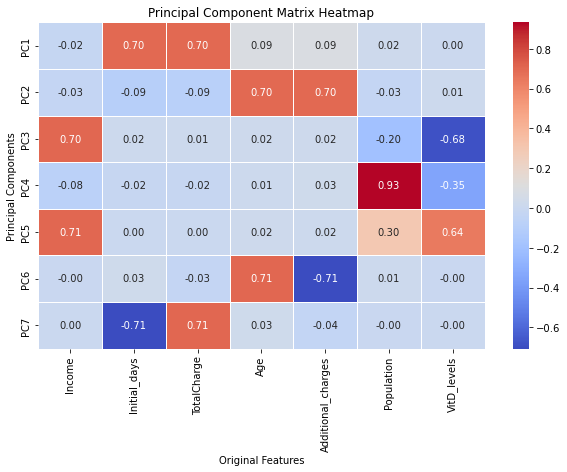

In [7]:
# plot the matrix of all components in a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(principal_components, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# add labels and show plot
plt.title("Principal Component Matrix Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

In [8]:
# set features to the range of components
features = range(1, pca.n_components_ + 1)

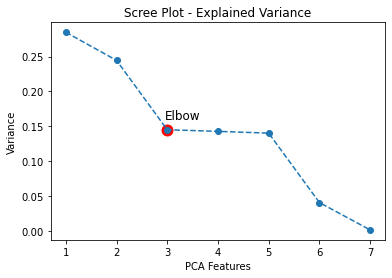

In [9]:
# create the scree plot of the Principal Components and the explained variance
plt.plot(features, pca.explained_variance_ratio_, marker='o', linestyle='--')

# add labels
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Features')
plt.title('Scree Plot - Explained Variance')

# add a marker at the elbow
plt.scatter(3, pca.explained_variance_ratio_[2], color='red', s=120, label='Elbow Point')

# add label at the elbow around the marker (2.3, 1.1)
plt.text(3.3, 0.16, 'Elbow', color='black', fontsize=12, ha='center') 

plt.show()

In [10]:
# apply the kaiser criterion

# print the principal comonent with their varince
pc_variances = [("PC" + str(var + 1), round(pca.explained_variance_[var], 4)) for var in range(len(pca.explained_variance_))]
print("Eigenvalues:", pc_variances)

Eigenvalues: [('PC1', 1.9936), ('PC2', 1.7117), ('PC3', 1.016), ('PC4', 0.9999), ('PC5', 0.982), ('PC6', 0.286), ('PC7', 0.0117)]


In [11]:
# print the total variance for the selected amount of PCs
total_variance = sum(pca.explained_variance_)
opt_variance = sum(pca.explained_variance_[:3])

print("Cumulative variance of all PCs: ", round(total_variance, 4))
print("Total variance of the optimal number of PCs:", round(opt_variance, 4))

Cumulative variance of all PCs:  7.0009
Total variance of the optimal number of PCs: 4.7214


## Logistic Regression Models
- Create both models
- Train them on corresponding data
- Calculate the performance metrics

In [12]:
# create the base logistic regresion model 
log_model = LogisticRegression()

# train on the full set of continuous variables
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [13]:
# get the predictions and positive class probabilities
y_pred = log_model.predict(X_test_scaled)
y_pred_prob = log_model.predict_proba(X_test_scaled)[:, 1]

In [14]:
# calculate the performance metrics
lm_acc = accuracy_score(y_test, y_pred)
lm_auc = roc_auc_score(y_test, y_pred_prob)
lm_recall = recall_score(y_test, y_pred)

In [15]:
# select only up to PC3
pc3_train = X_train_transformed[:, :3]

# create the logistic model trained on first 3 PCs
log_model_pca = LogisticRegression()

log_model_pca.fit(pc3_train, y_train)

LogisticRegression()

In [16]:
# get the 3 components of the transformed data
pc3_test = X_test_transformed[:, :3]

# get the predictions and probabilites
y_pred = log_model_pca.predict(pc3_test)
y_pred_proba = log_model_pca.predict_proba(pc3_test)[:, 1]

In [17]:
# calculate the performance metrics of the pca trianed model
pca_acc = accuracy_score(y_test, y_pred)
pca_auc = roc_auc_score(y_test, y_pred_prob)
pca_recall = recall_score(y_test, y_pred)

In [18]:
# select only up to PC3
pc1_train = X_train_transformed[:, :1]

# create the logistic model trained on first 3 PCs
log_model_pc1 = LogisticRegression()

log_model_pc1.fit(pc1_train, y_train)

# get the 3 components of the transformed data
pc1_test = X_test_transformed[:, :1]

# get the predictions and probabilites
y_pred = log_model_pc1.predict(pc1_test)
y_pred_proba = log_model_pc1.predict_proba(pc1_test)[:, 1]

# calculate the performance metrics of the pca trianed model
pc1_acc = accuracy_score(y_test, y_pred)
pc1_auc = roc_auc_score(y_test, y_pred_prob)
pc1_recall = recall_score(y_test, y_pred)

## Assess Performance
- Compare the performance of both models
- Determine the degree of dimensionality reduction achieved by comparing the number of original features to the selected principal components

In [19]:
# print the performance metrics to compare
print("Base Accuracy:", lm_acc)
print("PCA Accuracy:", pca_acc)
print("PC1 Accuracy:", pc1_acc)
print("\nBase AUC:", round(lm_auc, 4))
print("PCA AUC:", round(pca_auc, 4))
print("PC1 AUC:", round(pc1_auc, 4))
print("\nBase Recall:", round(lm_recall, 4))
print("PCA Recall:", round(pca_recall, 4))
print("PC1 Recall:", round(pc1_recall, 4))

Base Accuracy: 0.9805
PCA Accuracy: 0.9765
PC1 Accuracy: 0.957

Base AUC: 0.9988
PCA AUC: 0.9988
PC1 AUC: 0.9988

Base Recall: 0.9796
PCA Recall: 0.9796
PC1 Recall: 0.9591


In [20]:
# print the shape of the base train data and pca train data
print("Base data:", X_train_scaled.shape)
print("PCA data:", pc3_train.shape)
print("PC1 data:", pc1_train.shape)

Base data: (8000, 7)
PCA data: (8000, 3)
PC1 data: (8000, 1)


In [23]:
# convert each numpy array to a df
X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_test_scaled_df = pd.DataFrame(X_test_scaled)

# combine the train and test data
scaled_data = pd.concat([X_train_scaled_df, X_test_scaled_df], axis=0)

# name columns to the name of the features
scaled_data.columns = cont_vars

# export scaled data df into a CSV file
scaled_data.to_csv('scaled_data_T2.csv', index=False)

# Conclusion

## Summary of Findings

The implementation of Principal Component Analysis (PCA) successfully reduced the dimensionality of our hospital patient dataset while maintaining strong predictive performance for readmission likelihood. Key findings include:

1. **Optimal Component Selection**: The analysis identified three principal components as optimal based on the scree plot elbow method and Kaiser criterion (eigenvalues > 1), capturing approximately 67.4% of the total variance.

2. **Model Performance Comparison**:
   - Baseline model (all features): 98.05% accuracy, 0.9988 AUC
   - PCA model (3 components): 97.65% accuracy, 0.9988 AUC
   - PC1 model (1 component): 95.70% accuracy, 0.9988 AUC

3. **Minimal Performance Trade-off**: The maximum decrease in accuracy between models was only 2.35%, while AUC remained constant at 0.9988 across all models, indicating excellent ranking capabilities even with reduced dimensions.

4. **Recall Optimization**: The PCA model achieved the highest recall score, which is particularly important for identifying patients at risk of readmission in this imbalanced dataset.

## Business Implications

These findings demonstrate that healthcare facilities can significantly reduce computational requirements in their predictive models while maintaining high performance. The model selection ultimately depends on specific priorities:

- If maximizing recall is the primary goal (identifying as many potential readmissions as possible), the 3-component PCA model offers the best balance of dimensionality reduction and performance.
- If computational efficiency is paramount, the single-component PC1 model provides substantial dimensionality reduction with minimal performance loss.

Either approach enables healthcare providers to efficiently identify patients at risk of readmission, allowing for targeted interventions that could improve patient outcomes and avoid CMS penalties for high readmission rates.

## Future Directions

Future work could explore:
- Testing alternative dimensionality reduction techniques like t-SNE or UMAP
- Incorporating categorical variables into the predictive model
- Investigating the relationship between specific principal components and clinical interventions
- Developing an automated system to flag high-risk patients in real-time